In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.distributions as D

from clusterless.utils import NP1DataLoader, ADVIDataLoader, fit_initial_gmm
from clusterless.advi import ADVI

In [5]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [6]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [7]:
np1_data_loader = NP1DataLoader(
    probe_id = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 
    geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/np1_channel_map.npy', 
    ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtraction_results_threshold_5', 
    behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
)

Session ID: db4df448-e449-4a6f-a0e7-288711e7a75a
Probe ID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 (probe00)
First trial stimulus onset time: 40.81 sec
Last trial stimulus onset time: 2252.10 sec


In [92]:
trials = np1_data_loader.relocalize_kilosort(
    data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/kilosort_localizations',
    region = 'po')

Found 64 channels in region po


In [93]:
trials[0].max(0)

array([  41.80116323,  253.        ,   82.70218628, 2578.96002026,
         32.15045547])

In [94]:
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = \
    np1_data_loader.load_behaviors('dynamic')

In [95]:
advi_data_loader = ADVIDataLoader(
                         data = trials, 
                         behavior = motion_energy, 
                         n_t_bins = 30)

In [96]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf_train_ids = []
kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(advi_data_loader.behavior)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [97]:
i = 0
train_trials, train_trial_ids, train_time_ids, test_trials, test_trial_ids, test_time_ids = \
    advi_data_loader.split_train_test(kf_train_ids[i], kf_test_ids[i])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [98]:
train_trials.max(0)

array([ 253.        ,  159.        , 2640.        ,   52.97673035])

In [99]:
gmm = fit_initial_gmm(np.vstack([train_trials, test_trials]))

Channel 93 is split into 1 modes
Channel 97 is split into 1 modes
Channel 101 is split into 1 modes
Channel 102 is split into 2 modes
Channel 105 is split into 1 modes
Channel 106 is split into 1 modes
Channel 110 is split into 1 modes
Channel 114 is split into 1 modes
Channel 116 is split into 1 modes
Channel 118 is split into 1 modes
Channel 119 is split into 1 modes
Channel 120 is split into 1 modes
Channel 121 is split into 1 modes
Channel 122 is split into 1 modes
Channel 124 is split into 3 modes
Channel 125 is split into 1 modes
Channel 126 is split into 1 modes
Channel 131 is split into 1 modes
Channel 132 is split into 2 modes
Channel 133 is split into 1 modes
Channel 134 is split into 2 modes
Channel 136 is split into 3 modes
Channel 137 is split into 1 modes
Channel 138 is split into 2 modes
Channel 140 is split into 3 modes
Channel 141 is split into 3 modes
Channel 142 is split into 3 modes
Channel 144 is split into 2 modes
Channel 145 is split into 2 modes
Channel 146 is s

In [100]:
s = torch.tensor(train_trials[:,1:])
y = torch.tensor(advi_data_loader.behavior)
ks = torch.tensor(train_trial_ids)
ts = torch.tensor(train_time_ids)

Nk = len(advi_data_loader.train_ids)
Nt = advi_data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]
print(Nc)

57


#### ADVI

In [109]:
batch_size = 1
batch_ids = list(zip(*(iter(advi_data_loader.train_ids),) * batch_size))

In [110]:
advi = ADVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(advi.parameters(), lr=1e-2)

In [111]:
%%time
elbos = advi.train_advi(s, y, ks, ts, batch_ids, optim, max_iter=30)

iter: 1 batch 100
iter: 1 total elbo: -62.29
iter: 2 batch 100
iter: 2 total elbo: -40.84
iter: 3 batch 100
iter: 3 total elbo: -33.23
iter: 4 batch 100
iter: 4 total elbo: -29.53
iter: 5 batch 100
iter: 5 total elbo: -27.08
iter: 6 batch 100
iter: 6 total elbo: -25.29
iter: 7 batch 100
iter: 7 total elbo: -23.91
iter: 8 batch 100
iter: 8 total elbo: -22.72
iter: 9 batch 100
iter: 9 total elbo: -21.85
iter: 10 batch 100
iter: 10 total elbo: -21.22
iter: 11 batch 100
iter: 11 total elbo: -20.59
iter: 12 batch 100
iter: 12 total elbo: -20.22
iter: 13 batch 100
iter: 13 total elbo: -19.83
iter: 14 batch 100
iter: 14 total elbo: -19.53
iter: 15 batch 100
iter: 15 total elbo: -19.19
iter: 16 batch 100
iter: 16 total elbo: -18.95
iter: 17 batch 100
iter: 17 total elbo: -18.73
iter: 18 batch 100
iter: 18 total elbo: -18.60
iter: 19 batch 100
iter: 19 total elbo: -18.45
iter: 20 batch 100
iter: 20 total elbo: -18.27
iter: 21 batch 100
iter: 21 total elbo: -18.23
iter: 22 batch 100
iter: 22 tot

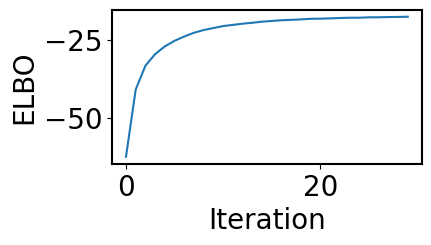

In [112]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [113]:
pis = advi.calc_dynamic_mixing_proportions(y)

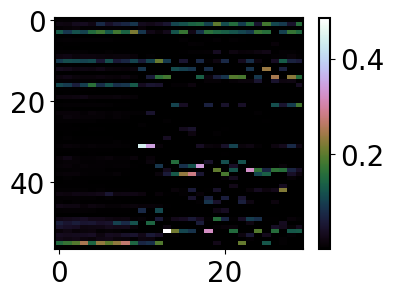

In [114]:
plt.figure(figsize=(4,3))
plt.imshow(pis.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

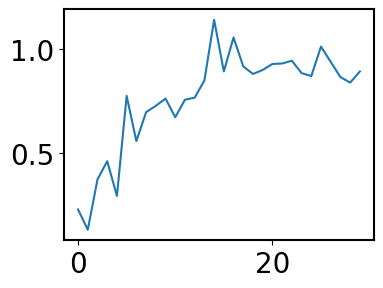

In [115]:
plt.figure(figsize=(4,3))
plt.plot(advi.beta.loc[1].detach().numpy());

In [116]:
def dynamic_decoder(x, y, train, test):
    '''
    
    '''
    x_train = x.reshape(-1, x.shape[1] * x.shape[2])[train]
    x_test = x.reshape(-1, x.shape[1] * x.shape[2])[test]
    y_train = y[train]
    y_test = y[test]

    ridge = Ridge(alpha=1000)
    ridge.fit(x_train, y_train)
    y_pred = ridge.predict(x_test)
    
    print(f'R2: {r2_score(y_test, y_pred):.3f}, MSE: {mean_squared_error(y_test, y_pred):.3f}, Corr: {pearsonr(y_test.flatten(), y_pred.flatten()).statistic:.3f}')
    
    return y_train, y_test, y_pred

#### GMM

In [117]:
trials = np1_data_loader.relocalize_kilosort(
    data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/kilosort_localizations',
    region = 'po')

Found 64 channels in region po


In [118]:
spike_train = np.concatenate(trials)
spike_times = spike_train[:,0]
spike_labels = gmm.predict(spike_train[:,2:])
spike_probs = gmm.predict_proba(spike_train[:,2:])

In [119]:
vanilla_gmm = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_labels, spike_probs],
    is_gmm = True, n_t_bins = 30, regional = True)
print(vanilla_gmm.shape)

(230, 57, 30)


In [120]:
train = advi_data_loader.train_ids
test = advi_data_loader.test_ids

In [132]:
y_train, y_test, y_pred = dynamic_decoder(vanilla_gmm, advi_data_loader.behavior, train, test)

R2: 0.164, MSE: 5.344, Corr: 0.894


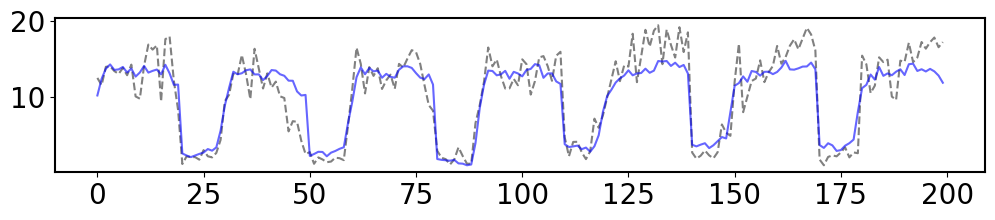

In [122]:
plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

#### multi-unit thresholding

In [125]:
spike_train = np.concatenate(trials)
spike_times = spike_train[:,0]
spike_channels = spike_train[:,1]

In [127]:
thresholded = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_channels],
    is_gmm = False, n_t_bins = 30, regional = True)
print(thresholded.shape)

(230, 39, 30)


In [130]:
y_train, y_test, y_pred = dynamic_decoder(thresholded, advi_data_loader.behavior, train, test)

R2: 0.152, MSE: 5.458, Corr: 0.892


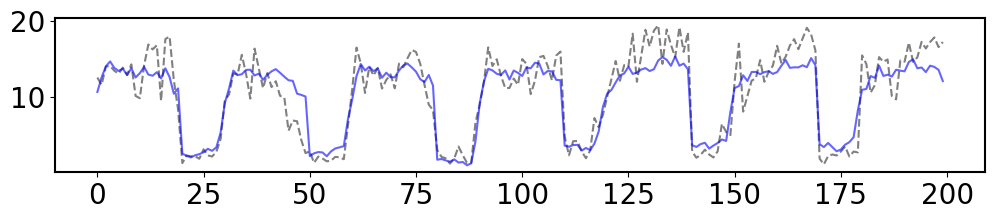

In [131]:
plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

#### encoding MoG

In [133]:
enc_pis, enc_all = advi.encode_gmm(advi_data_loader.trials, train, test, y_train, y_pred)

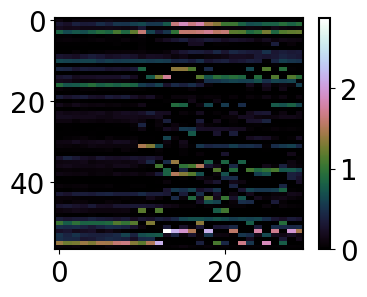

In [134]:
plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

In [135]:
y_train, y_test, y_pred = dynamic_decoder(enc_all, advi_data_loader.behavior, train, test)

R2: 0.158, MSE: 5.318, Corr: 0.895


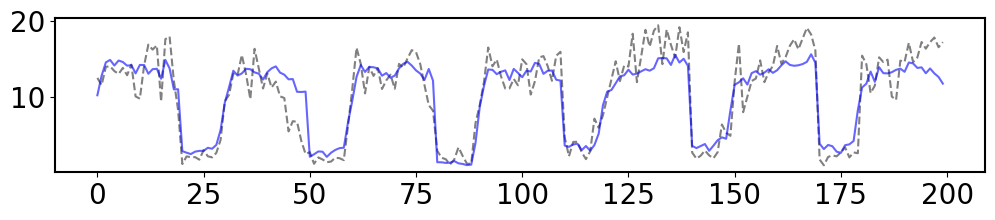

In [136]:
plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

#### KS all units

In [137]:
ks_all = np1_data_loader.load_all_units(region='po')
ks_all = np.concatenate(ks_all)

Found 88 KS units in region po


In [138]:
all_units = np1_data_loader.prepare_decoder_input(
    ks_all,
    is_gmm = False, n_t_bins = 30, regional = True)
print(all_units.shape)

(230, 86, 30)


In [139]:
y_train, y_test, y_pred = dynamic_decoder(all_units, advi_data_loader.behavior, train, test)

R2: 0.149, MSE: 5.439, Corr: 0.893


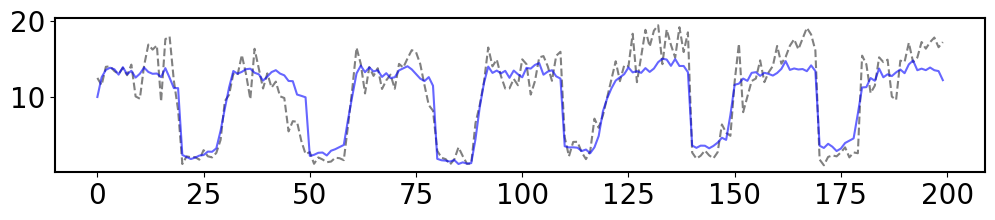

In [140]:
plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);

#### KS good units

In [141]:
ks_good = np1_data_loader.load_good_units(region='po')
ks_good = np.concatenate(ks_good)

Found 18 good units in region po


In [142]:
good_units = np1_data_loader.prepare_decoder_input(
    ks_good,
    is_gmm = False, n_t_bins = 30, regional = True)
print(good_units.shape)

(230, 18, 30)


In [143]:
y_train, y_test, y_pred = dynamic_decoder(good_units, advi_data_loader.behavior, train, test)

R2: 0.131, MSE: 5.599, Corr: 0.889


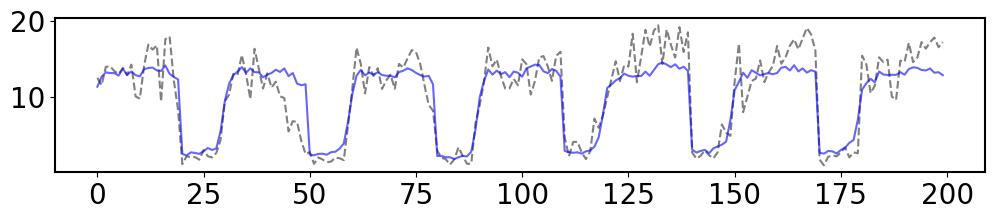

In [144]:
plt.figure(figsize=(12, 2))
plt.plot(y_test.flatten()[-200:], c='gray', linestyle='dashed');
plt.plot(y_pred.flatten()[-200:], c='blue', alpha=.6);